In [3]:
import pandas as pd
import numpy as np
import html
import nltk
import regex as re
import string
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [4]:
# data = pd.read_csv('C:/Users/Danilo/Desktop/Documentos Acadêmicos/TERA/TERAprojetos/Projeto final/BNCC/repo/bncc-classifier/data/curated/data_eda_treat_will.csv')
data = pd.read_csv("../../data/curated/data_eda_treat_will.csv")



In [5]:
data_clone = data.copy()

In [6]:
# renomeando as colunas do dataset

data_clone.columns = ['id', 'questoes', 'tipoQuestoes', 'topico', 'slug', 'materia', 'slug.1','etapaEnsino']
data_clone.drop(['slug', 'slug.1'], axis = 1, inplace = True)
data_clone.head()

,id,questoes,tipoQuestoes,topico,materia,etapaEnsino
0,3486670,<p>Com base em seus conhecimentos sobre o comp...,2,História da Arte,Arte,Fundamental II
1,3343927,"<p>&ldquo;Achar um n&uacute;mero que, somado c...",2,Álgebra: Equações do 2º grau: Equação do 2º gr...,Matemática,Fundamental II
2,3691951,"<p style=""padding:0px;margin:10px 0px 0px;outl...",2,Outros,Química,Fundamental II
3,2016466,<p><strong>Anexe nesse espa&ccedil;o uma foto ...,4,Proposta,Língua Portuguesa,Fundamental I
4,1744035,<p>Pagina nr. 54 do Livro did&aacute;tico.</p>,4,Idade Moderna: Revolução Francesa: Antecedente...,História,Fundamental II


## Pre-processamento

* Escrevendo funcões para etapa de pre-processamento de Texto usando regex 

In [7]:
# Função para remover tags de html usando regex

def remove_tags(text: str) -> str:
    pattern = re.compile("<.*?>")
    cleantext = re.sub(pattern, " ", text).replace(u"\xa0", u" ")
    return cleantext

# Função para deixar todo o texto em caixa baixa
def to_lower(text: str) -> str:
    return text.lower()

# Função para remover numeros
def remove_numbers(text: str) -> str:
    pattern = re.compile("[0-9]+")
    clean_text = re.sub(pattern, " ", text)
    return clean_text

# Função para remover stopwords em portugues; preposições, conjunções, artigos, etc
def remove_standard_stopwords_pt(text: str) -> str:
    stop_words = set(stopwords.words("portuguese"))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    final_sentence = " ".join(filtered_sentence)
    return final_sentence  

def remove_standard_stopwords_en(text: str) -> str:
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    final_sentence = " ".join(filtered_sentence)
    return final_sentence  

# Função para remover caracteres especiais e pontuação
def remove_punctuation(text: str) -> str:
    pattern = re.compile("[\d\.\,\*):(\?\!\;\/\-\]\[\–º_=]")
    clean_text = re.sub(pattern, " ", text)
    return clean_text

# Função para remover aspas em itálico
def remove_italic_dquotes(text: str) -> str:
    pattern = re.compile(r'"')
    clean_text = re.sub(pattern, " ", text)
    return clean_text

# Função para remover aspas de abertura
def remove_open_dquotes(text: str) -> str:
    pattern = re.compile(r'“')
    clean_text = re.sub(pattern, " ", text)
    return clean_text

# Função para remover aspas de abertura
def remove_end_dquotes(text: str) -> str:
    pattern = re.compile(r'”')
    clean_text = re.sub(pattern, " ", text)
    return clean_text

# Função para remover aspas de abertura
def remove_italic_quotes(text: str) -> str:
    pattern = re.compile(r"'")
    clean_text = re.sub(pattern, " ", text)
    return clean_text

# Função para remover aspas de abertura
def remove_open_quotes(text: str) -> str:
    pattern = re.compile(r'‘')
    clean_text = re.sub(pattern, " ", text)
    return clean_text

# Função para remover aspas de abertura
def remove_end_quotes(text: str) -> str:
    pattern = re.compile(r'’')
    clean_text = re.sub(pattern, " ", text)
    return clean_text

# Função para remover aspas de abertura
def remove_quote(text: str) -> str:
    pattern = re.compile(r'‛')
    clean_text = re.sub(pattern, " ", text)
    return clean_text

In [8]:
# resolve problema de codificação html da coluna 'questoes'
data_clone['questoes_html']= data_clone['questoes'].astype('str').apply(html.unescape)

# limpando o texto utilizando as funçoes criadas
data_clone['questoes_tags'] = data_clone['questoes_html'].apply(remove_tags)
data_clone['questoes_lower'] = data_clone['questoes_tags'].apply(to_lower)
data_clone['questoes_numbers'] = data_clone['questoes_lower'].apply(remove_numbers)

### limpando pontuações e todos os tipos de aspas

data_clone['questoes_punct'] = data_clone['questoes_numbers'].apply(remove_punctuation)

data_clone['questoes_no_italic_quotes'] = data_clone['questoes_punct'].apply(remove_italic_quotes)
data_clone['questoes_no_open_quotes'] = data_clone['questoes_no_italic_quotes'].apply(remove_open_quotes)
data_clone['questoes_no_end_quotes'] = data_clone['questoes_no_open_quotes'].apply(remove_end_quotes)

data_clone['questoes_no_italic_dquotes'] = data_clone['questoes_no_end_quotes'].apply(remove_italic_dquotes)
data_clone['questoes_no_open_dquotes'] = data_clone['questoes_no_italic_dquotes'].apply(remove_open_dquotes)
data_clone['questoes_no_end_dquotes'] = data_clone['questoes_no_open_dquotes'].apply(remove_end_dquotes)

data_clone['questoes_no_quotes'] = data_clone['questoes_no_end_dquotes'].apply(remove_quote)


In [9]:
stop_en = stopwords.words('english')

text_en = data_clone['questoes_no_quotes']

test = pd.DataFrame(text_en)
test.columns = ["text"]

test['text_without_stopwords'] = test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_en)]))
data_clone['questoes_no_stopw_en'] = test['text_without_stopwords']

In [10]:
print(data_clone['questoes_no_stopw_en'][83621])
print(data_clone['questoes_no_quotes'][83621])

choose correct alternative work yesterday
  choose the correct alternative            did you work yesterday  


In [12]:
!python -m spacy download pt_core_news_sm

     |████████████████████████████████| 22.2 MB 129 kB/s            
You should consider upgrading via the '/home/luba/.local/share/virtualenvs/bncc-classifier-AU87OF4y/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [13]:
nlp = spacy.load('pt_core_news_sm')

In [14]:
data_sample = data_clone.sample(1000, random_state= 42)

In [15]:
doc_spacy = list(nlp.pipe(data_sample.questoes_no_quotes))

In [16]:
def extract_tokens_plus_meta(doc:spacy.tokens.doc.Doc):
    """Extract tokens and metadata from individual spaCy doc."""
    return [
        (i.text, i.i, i.lemma_, i.ent_type_, i.tag_, 
         i.dep_, i.pos_, i.is_stop, i.is_alpha, 
         i.is_digit, i.is_punct) for i in doc
    ]

In [17]:
def tidy_tokens(docs):
    """Extract tokens and metadata from list of spaCy docs."""
    
    cols = [
        "doc_id", "token", "token_order", "lemma", 
        "ent_type", "tag", "dep", "pos", "is_stop", 
        "is_alpha", "is_digit", "is_punct"
    ]
    
    meta_df = []
    for ix, doc in enumerate(docs):
        meta = extract_tokens_plus_meta(doc)
        meta = pd.DataFrame(meta)
        meta.columns = cols[1:]
        meta = meta.assign(doc_id = ix).loc[:, cols]
        meta_df.append(meta)
        
    return pd.concat(meta_df)

In [18]:
tidy_docs = tidy_tokens(doc_spacy)

In [19]:
tidy_docs = tidy_docs.query("is_stop == False & tag != 'SPACE'")
tidy_docs

,doc_id,token,token_order,lemma,ent_type,tag,dep,pos,is_stop,is_alpha,is_digit,is_punct
2,0,água,2,água,,NOUN,nsubj:pass,NOUN,False,True,False,False
3,0,adequada,3,adequar,,ADJ,amod,ADJ,False,True,False,False
6,0,consumo,6,consumir,,NOUN,obl,NOUN,False,True,False,False
8,0,chamada,8,chamar,,VERB,ROOT,VERB,False,True,False,False
2,1,tarefa,2,tarefar,,NOUN,nsubj,NOUN,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
50,999,destinação,50,destinação,,NOUN,conj,NOUN,False,True,False,False
52,999,lixo,52,lixar,,NOUN,nmod,NOUN,False,True,False,False
54,999,marque,54,marcar,,NOUN,ROOT,NOUN,False,True,False,False
56,999,alternativa,56,alternativo,,NOUN,obj,NOUN,False,True,False,False


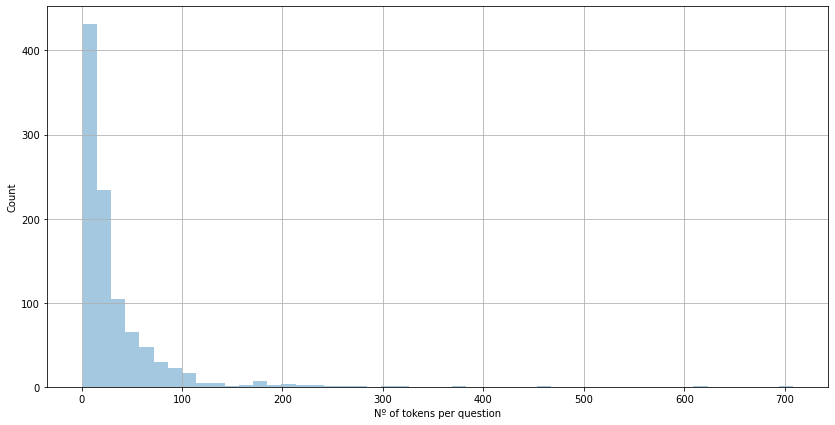

In [20]:
tidy_docs.groupby("doc_id").size().hist(figsize=(14, 7), alpha=.4, bins=50)
plt.xlabel("Nº of tokens per question")
plt.ylabel("Count")
plt.show()

In [21]:
tidy_docs.query("ent_type != ''").ent_type.value_counts()

MISC    1001
PER      609
LOC      603
ORG      142
Name: ent_type, dtype: int64

(array([  0.,  50., 100., 150., 200., 250.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

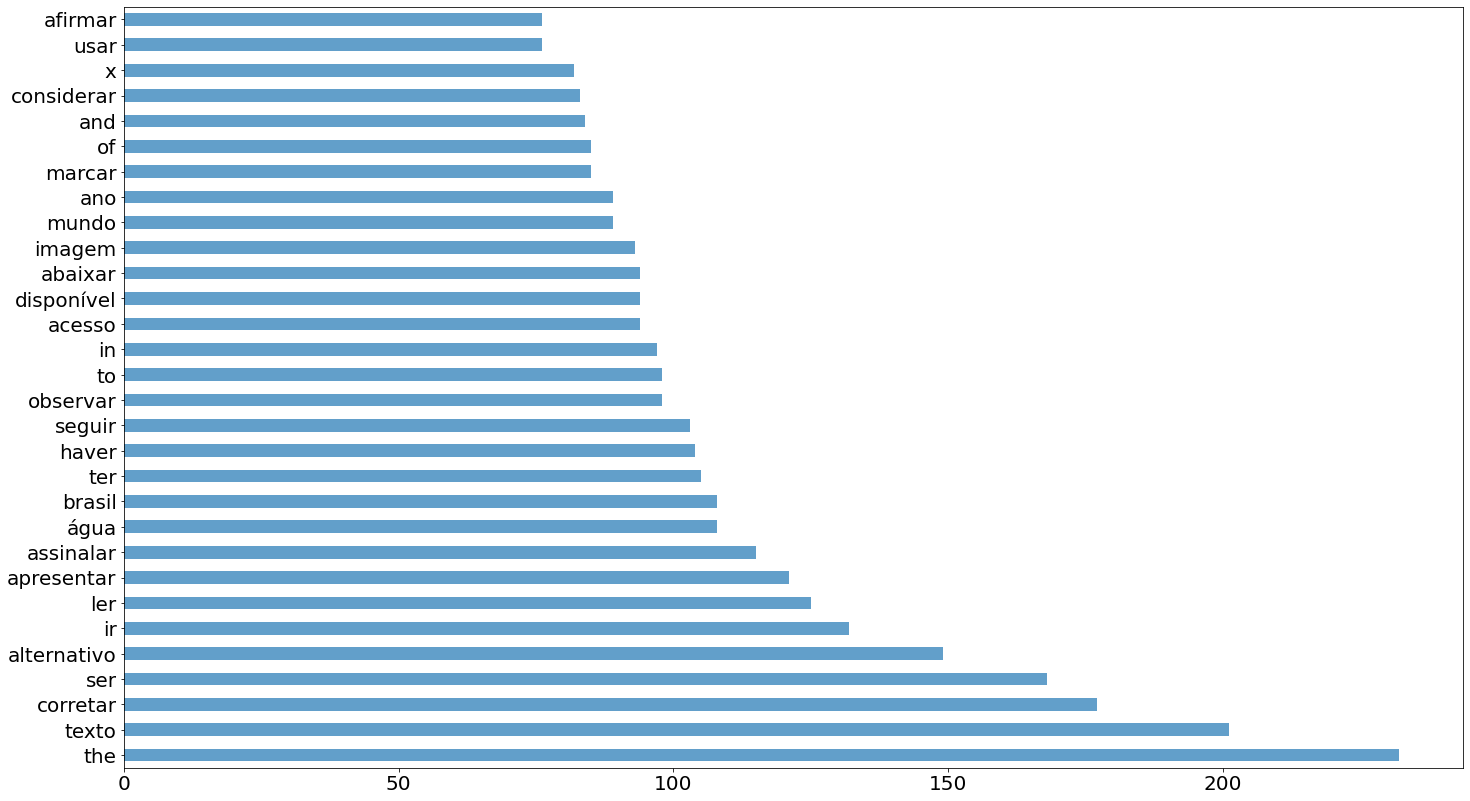

In [22]:
tidy_docs.lemma.value_counts(sort = True, ascending = False).head(30).plot(kind="barh", figsize=(24, 14), alpha=.7)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

In [25]:
tidy_docs.groupby(["doc_id"])["lemma"].agg(list)

doc_id
0                      [água, adequar, consumir, chamar]
1       [tarefar, página, livrar, atividades, exercício]
2      [trocar, presente, comum, natal, embalar, lemb...
3      [ler, seguinte, afirmação, obrar, lucíola, jos...
4      [imagem, abaixar, representação, escalar, gráf...
                             ...                        
994    [aristóteles, preconizar, virtude, ter, atitud...
996    [conformar, apresentar, poema, retratar, mulhe...
997    [utilitarismo, propor, princípio, utilidade, f...
998    [pucpr, livrar, vigiar, punir, michel, foucaul...
999    [saneamento, básico, conjuntar, cuidar, água, ...
Name: lemma, Length: 986, dtype: object

In [28]:
data_sample

,id,questoes,tipoQuestoes,topico,materia,etapaEnsino,questoes_html,questoes_tags,questoes_lower,questoes_numbers,questoes_punct,questoes_no_italic_quotes,questoes_no_open_quotes,questoes_no_end_quotes,questoes_no_italic_dquotes,questoes_no_open_dquotes,questoes_no_end_dquotes,questoes_no_quotes,questoes_no_stopw_en
48147,2969119,<p>3- A &aacute;gua adequada para o consumo &e...,2,Terra e Universo,Ciências,Fundamental I,<p>3- A água adequada para o consumo é chamada...,3- A água adequada para o consumo é chamada de:,3- a água adequada para o consumo é chamada de:,- a água adequada para o consumo é chamada de:,a água adequada para o consumo é chamada de,a água adequada para o consumo é chamada de,a água adequada para o consumo é chamada de,a água adequada para o consumo é chamada de,a água adequada para o consumo é chamada de,a água adequada para o consumo é chamada de,a água adequada para o consumo é chamada de,a água adequada para o consumo é chamada de,água adequada para consumo é chamada de
6432,2284045,<p>A tarefa de voc&ecirc;s est&aacute; na p&aa...,4,"Terra e Universo: Forma, estrutura e movimento...",Ciências,Fundamental II,<p>A tarefa de vocês está na página 18 do <str...,A tarefa de vocês está na página 18 do LIVR...,a tarefa de vocês está na página 18 do livr...,a tarefa de vocês está na página do livro...,a tarefa de vocês está na página do livro...,a tarefa de vocês está na página do livro...,a tarefa de vocês está na página do livro...,a tarefa de vocês está na página do livro...,a tarefa de vocês está na página do livro...,a tarefa de vocês está na página do livro...,a tarefa de vocês está na página do livro...,a tarefa de vocês está na página do livro...,tarefa de vocês está na página livro de ativid...
57085,3989479,<p>A troca de presentes &eacute; muito comum n...,2,Geometria Plana: Áreas de figuras planas,Matemática,Fundamental II,<p>A troca de presentes é muito comum no natal...,"A troca de presentes é muito comum no natal, ...","a troca de presentes é muito comum no natal, ...","a troca de presentes é muito comum no natal, ...",a troca de presentes é muito comum no natal ...,a troca de presentes é muito comum no natal ...,a troca de presentes é muito comum no natal ...,a troca de presentes é muito comum no natal ...,a troca de presentes é muito comum no natal ...,a troca de presentes é muito comum no natal ...,a troca de presentes é muito comum no natal ...,a troca de presentes é muito comum no natal ...,troca de presentes é muito comum natal para em...
55999,29452,<p>Leia as seguintes afirmações sobre a obra L...,2,Literatura Brasileira: Romantismo: Prosa,Língua Portuguesa,Médio & Pré-Vestibular,<p>Leia as seguintes afirmações sobre a obra L...,Leia as seguintes afirmações sobre a obra Luc...,leia as seguintes afirmações sobre a obra luc...,leia as seguintes afirmações sobre a obra luc...,leia as seguintes afirmações sobre a obra luc...,leia as seguintes afirmações sobre a obra luc...,leia as seguintes afirmações sobre a obra luc...,leia as seguintes afirmações sobre a obra luc...,leia as seguintes afirmações sobre a obra luc...,leia as seguintes afirmações sobre a obra luc...,leia as seguintes afirmações sobre a obra luc...,leia as seguintes afirmações sobre a obra luc...,leia seguintes afirmações sobre obra lucíola d...
80510,2076459,<p>Qual das imagens abaixo tem a representa&cc...,2,A divisão política do Brasil,Geografia,Fundamental II,<p>Qual das imagens abaixo tem a representação...,Qual das imagens abaixo tem a representação d...,qual das imagens abaixo tem a representação d...,qual das imagens abaixo tem a representação d...,qual das imagens abaixo tem a representação d...,qual das imagens abaixo tem a representação d...,qual das imagens abaixo tem a representação d...,qual das imagens abaixo tem a representação d...,qual das imagens abaixo tem a representação d...,qual das imagens abaixo tem a representação d...,qual das imagens abaixo tem a representação d...,qual das imagens abaixo tem a represe